In [1]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import math

In [2]:
# use GPU
if torch.backends.mps.is_available():
    processor = 'mps'
elif torch.cuda.is_available():
    processor = 'cuda'
else:
    processor = 'cpu'
device = torch.device(processor)
print(device)

mps


In [6]:
def mandelbrot(xpixels=5000, maxiter=100, xmin=-6, xmax=6, ymin=-6, ymax=6):

    # Compute ypixels so the image is not stretched (1:1 ratio)
    ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))
    
    # Initialisation of result to 0
    mat = np.zeros((xpixels, ypixels),)
    
    # Looping through pixels
    for x in range(xpixels):
        for y in range(ypixels):
            
            # Mapping pixel to C
            creal = xmin + x / xpixels * (xmax - xmin)
            cim = ymin + y / ypixels * (ymax - ymin)
            
            # Initialisation of C and Z
            c = complex(creal, cim)
            z = complex(0, 0)
            
            # Mandelbrot iteration
            for n in range(maxiter):
                z = z - complex(0.002,0.002) * ((3*z+54) / (3))
                # If unbounded: save iteration count and break
                if z.real*z.real + z.imag*z.imag > 4.0:
                    # Smooth iteration count
                    mat[x,y] = n + 1 - math.log(math.log(abs(z*z+c)))/math.log(2)
                    break
                # Otherwise: leave it to 0
    return(mat)

In [7]:
def draw_image(mat, cmap='inferno', powern=0.5, dpi=72):
    ## Value normalization
    # Apply power normalization, because number of iteration is 
    # distributed according to a power law (fewer pixels have 
    # higher iteration number)
    mat = np.power(mat, powern)
    
    # Colormap: set the color the black for values under vmin (inner points of
    # the set), vmin will be set in the imshow function
    new_cmap = copy.copy(cm.get_cmap(cmap))
    new_cmap.set_under('black')
    
    ## Plotting image
    
    # Figure size
    plt.figure(figsize=(mat.shape[0]/dpi, mat.shape[1]/dpi))
    
    # Plotting mat with cmap
    # vmin=1 because smooth iteration count is always > 1
    # We need to transpose mat because images use row-major
    # ordering (C convention)
    # origin='lower' because mat[0,0] is the lower left pixel
    plt.imshow(mat.T, cmap=new_cmap, vmin=1, origin = 'lower')
    
    # Remove axis and margins
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis()

In [8]:
# Running and plotting result
mat = mandelbrot()
draw_image(mat, cmap='hot')

/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1686380934311/work/aten/src/ATen/native/TensorShape.cpp:3492.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CPU times: user 2.24 s, sys: 576 ms, total: 2.81 s
Wall time: 7.22 s


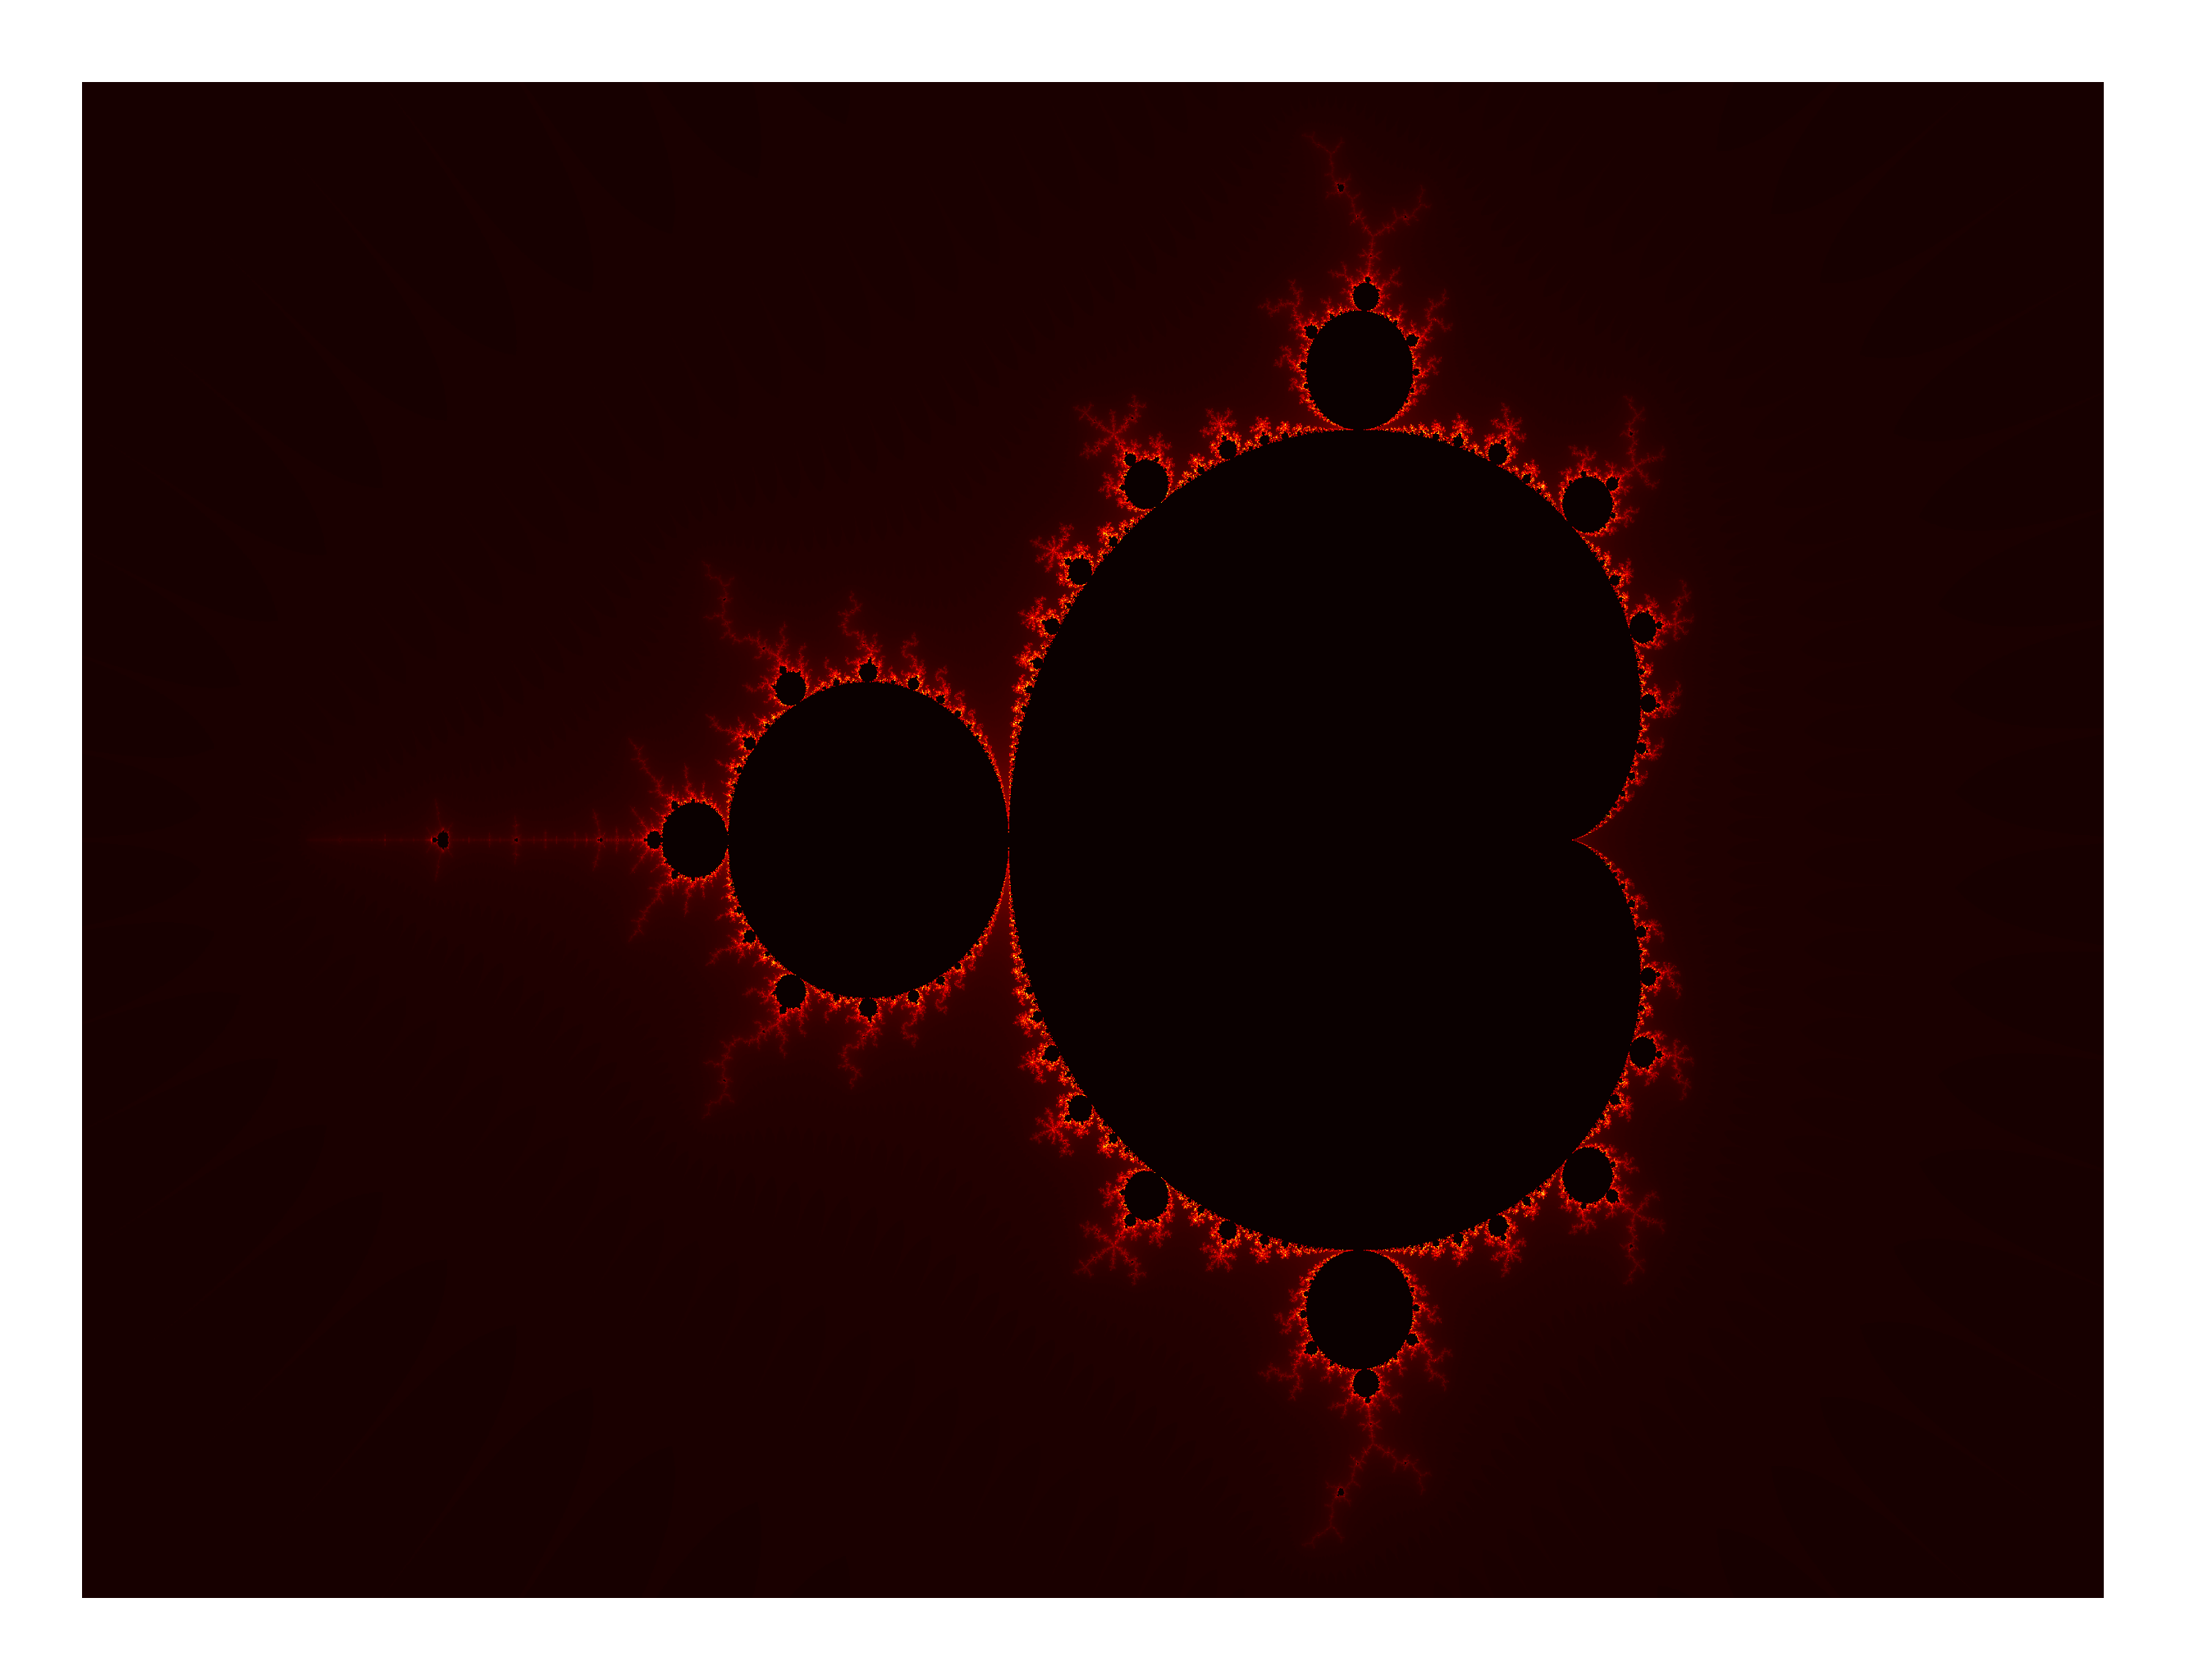

In [3]:
import torch
import matplotlib.pyplot as plt #for plotting

def compute_Mandelbrot(xmin = -2.4, xmax = 1.2, ymin = -1.2, ymax = 1.2, w = 3200, h = 2400, maxiter = 256):
    
    x = torch.linspace(xmin, xmax, w, dtype=torch.float,device=device).type(torch.half) #w = window's width in pixels; xmin, xmax = left and right borders of the window
    y = torch.linspace(ymin, ymax, h, dtype=torch.float,device=device).type(torch.half) #h = window's height in pixels; ymin, ymax = bottom and up borders of the window
    
    #create two tensors, containing respectively all x and y coordinates of all the points in the window. c=[cx,cy]
    cx, cy = torch.meshgrid([x,y])
   
    #set initial value of variable z to zero for the z=z^2+c iteration
    zx = torch.zeros(w*h, dtype=torch.float32,device=device).type(torch.half).resize_as_(cx)
    zy = torch.zeros(w*h, dtype=torch.float32,device=device).type(torch.half).resize_as_(cy)
    #Alternatively: zx = torch.zeros(w*h, dtype=torch.float32).cuda().type(torch.half).reshape(w,h)
    
    #will represent the color of the pixel, ininitialy 0. Tensor's shape is the same as that of cx, cy, zx and zy
    k = torch.zeros(w*h, dtype=torch.uint8,device=device).reshape(w,h)
    
    #main loop implementing z = z**2 + c iteration:
    #z**2 + c = (zx+zyi)**2 + (cx+cyi) = (zx**2-zy**2+cx)+(2*zx*zy+cy)i
    for i in range(maxiter):
        zx2 = zx**2
        zy2 = zy**2
        #inf is a tensor containing all the points for which zx2+zy2>4
        inf = (zx2+zy2)>4 #if zx2+zy2>4 then sqrt(zx2+zy2)>2, i.e. point's distance from (0,0) is >2, i.e. it will escape to inifinity; 
        k[inf] = i #for all the points escaping to infinity, store the number of iteration when that was this discovered
        zxn = zx2 - zy2 + cx #
        zyn = 2*zx*zy + cy
        zx = zxn
        zy = zyn
            
    return k.t()

%time M = compute_Mandelbrot(xmin = -2.4, xmax = 1.2, ymin = -1.2, ymax = 1.2, w = 3200, h = 2400, maxiter = 256)
M = M.cpu()
plt.figure(figsize=(3.200, 2.400), dpi=1000)
img = plt.imshow(M)
img.set_cmap('hot')
plt.axis('off')
plt.savefig('myfig.png', dpi=1000)